# Ensemble

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "regression"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

import platform
from matplotlib import font_manager, rc

#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
import warnings
warnings.filterwarnings(action='ignore')

# 투표 기반 분류기

## 여러 분류기를 이용한 sklearn 의 투표 기반 분류기

In [3]:
# 데이터 생성
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# print(X[0:5]) # x는 2행
# print(y[0:5]) # y는 2개의 feature
#모델 생성 및 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
#평가 지표 확인
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### 간접 투표 방식으로 변경

In [5]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 배깅 과 페이스팅

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


### 간접 투표 방식

In [7]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


#### oob 평가

In [8]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

## RandomForest

### 배깅 과 랜덤 포리스트 분류기 비교

In [9]:
#배깅을 이용한 random forest 만들기
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
#random forest 분류기
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [11]:
print(np.sum(y_pred == y_pred_rf) / len(y_pred))

1.0


In [24]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')
#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

#n_estimators는 나무의 개수
#n_jobs는 모델 훈련을 할 때의 코어의 개수
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = forest.predict(X_test) 

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
tree_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(tree_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test, y_hat)            
print(tree_report)


print('accuracy:',(tree_matrix[0,0]+tree_matrix[1,1])/np.sum(tree_matrix))

[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


[[106  19]
 [ 27  63]]


              precision    recall  f1-score   support

           0       0.80      0.85      0.82       125
           1       0.77      0.70      0.73        90

    accuracy                           0.79       215
   macro avg       0.78      0.77      0.78       215
weighted avg       0.78      0.79      0.78       215

accuracy: 0.786046511627907


(-1.0, 9.0)

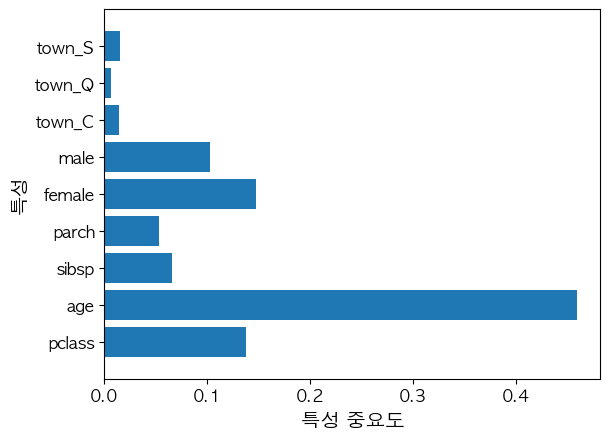

In [26]:
n_features = X.data.shape[1]
plt.barh(np.arange(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S'])
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)

In [28]:
forest.feature_importances_  # 특성중요도지만 index 가 없어 알 수 없다.

array([0.13709107, 0.45865121, 0.06560697, 0.05282623, 0.14700773,
       0.10273132, 0.01421708, 0.00667365, 0.01519474])

# Boosting

## ada boost

In [32]:
# ada Boost
from sklearn.ensemble import AdaBoostClassifier
# algorithms 은 확률을 계산할 수 있으면 SAMME.R
# 없다면 SAMME
# learning Rate = 학습률
# 학습률이 너무 크면 최적화 되지 않을 확률이 높고 너무 작으면 훈련 속도가 너무 느려지게 된다.또한 overfitting 우려가 있다. 

ada_clf=AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train, y_train)

y_hat=ada_clf.predict(X_test)
print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 0 1 0 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]


## Gradient Boosting

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(gb_pred[0:10])
print(y_test.values[0:10])


print('GBM 정확도: {0:.4f}'.format(gb_accuracy))


[0 1 1 0 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]
GBM 정확도: 0.7953


In [38]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 100}
최고 예측 정확도: 0.7896


In [39]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.8372


In [40]:
gbm_predict=metrics.classification_report(y_test,gb_pred)
print(gbm_predict)

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       125
           1       0.89      0.70      0.78        90

    accuracy                           0.84       215
   macro avg       0.85      0.82      0.83       215
weighted avg       0.84      0.84      0.83       215

